## **SMS Spam Detection**

### **Real-World Scenario**
Mobile users frequently receive unwanted promotional or fraudulent messages via SMS. These spam messages not only annoy users but also pose risks such as phishing and scams.

### **Stakeholder**
A telecom company wants to protect its customers and infrastructure by automatically detecting and filtering out spam SMS messages.

### **How This Project Helps**
This NLP pipeline processes and classifies SMS messages as either 'spam' or 'ham' (non-spam). By integrating this model, the telecom provider can:
- Reduce bandwidth consumption caused by mass spam sending.
- Protect users from phishing and fraud.
- Improve overall customer trust and experience.


**Data Acquisition & Exploration**

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfre

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv", sep='\t', names=['label', 'message'])

In [ ]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


(5572, 2)


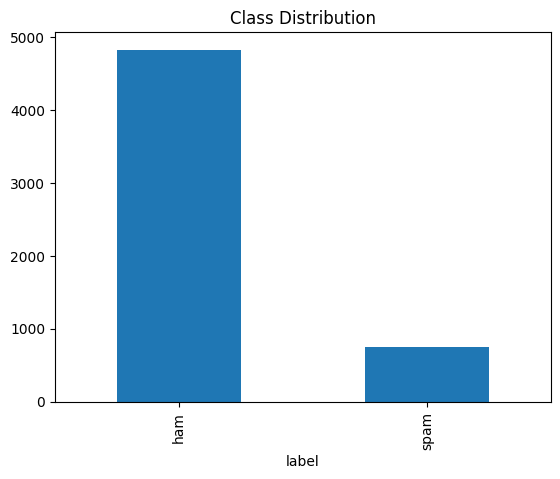

In [ ]:
print(df.shape)
df['label'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

In [ ]:
# Show examples
for label in df['label'].unique():
    print(f"\n--- Examples for class: {label} ---")
    print(df[df['label'] == label]['message'].sample(3).values)


--- Examples for class: ham ---
['Ah, well that confuses things, doesn‘t it?'
 "I'm in a movie... Collect car oredi..."
 'From here after The performance award is calculated every two month.not for current one month period..']

--- Examples for class: spam ---
['U’ve Bin Awarded £50 to Play 4 Instant Cash. Call 08715203028 To Claim. EVERY 9th Player Wins Min £50-£500. OptOut 08718727870'
 'Missed call alert. These numbers called but left no message. 07008009200'
 'Text82228>> Get more ringtones, logos and games from www.txt82228.com. Questions: info@txt82228.co.uk']


**Pre‑processing Pipeline**

In [ ]:
# Download only stopwords
nltk.download('stopwords', quiet=True)

# Basic fallback sentence tokenizer using regex
def fallback_sent_tokenize(text):
    return re.split(r'(?<=[.!?])\s+', text.strip())

# Basic word tokenizer using regex (no punkt)
def fallback_word_tokenize(text):
    return re.findall(r'\b\w+\b', text)

def preprocess_text(text):
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove emojis
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove non-alphanumeric except spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Sentence tokenization
    sentences = fallback_sent_tokenize(text)

    processed_sentences = []
    for sentence in sentences:
        # Tokenize to words without NLTK punkt
        tokens = fallback_word_tokenize(sentence)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        processed_sentences.append(tokens)

    # Flatten
    flattened_tokens = [token for sentence_tokens in processed_sentences for token in sentence_tokens]

    return flattened_tokens



In [ ]:
df['processed_text'] = df['message'].apply(preprocess_text)
df.head()

,label,message,processed_text
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


## **Feature Engineering**

In [ ]:
# Join tokens to strings for vectorization
df['joined_text'] = df['processed_text'].apply(lambda tokens: ' '.join(tokens))

In [ ]:
bow = CountVectorizer(ngram_range=(1,2))
X_bow = bow.fit_transform(df['joined_text'])


In [ ]:
# TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['joined_text'])

In [ ]:
# Word2Vec
tokens = [text.split() for text in df['joined_text']]
w2v_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def vector_average(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.array([vector_average(text, w2v_model) for text in tokens])

**Modelling & Evaluation**

In [ ]:
y = df['label'].map({'ham':0, 'spam':1})

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

def train_and_evaluate(model, X_train, X_test, y_train, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, digits=4))
    return accuracy_score(y_test, y_pred)

results = {}

In [ ]:
# Naive Bayes (only on sparse)
results['NB-BOW'] = train_and_evaluate(MultinomialNB(), X_train_bow, X_test_bow, y_train, y_test, "Naïve Bayes - BOW")
results['NB-TFIDF'] = train_and_evaluate(MultinomialNB(), X_train_tfidf, X_test_tfidf, y_train, y_test, "Naïve Bayes - TFIDF")

# Logistic Regression
results['LR-BOW'] = train_and_evaluate(LogisticRegression(), X_train_bow, X_test_bow, y_train, y_test, "Logistic Regression - BOW")
results['LR-TFIDF'] = train_and_evaluate(LogisticRegression(), X_train_tfidf, X_test_tfidf, y_train, y_test, "Logistic Regression - TFIDF")
results['LR-W2V'] = train_and_evaluate(LogisticRegression(), X_train_w2v, X_test_w2v, y_train, y_test, "Logistic Regression - Word2Vec")

# SVM
results['SVM-TFIDF'] = train_and_evaluate(LinearSVC(), X_train_tfidf, X_test_tfidf, y_train, y_test, "SVM - TFIDF")



Naïve Bayes - BOW Results:
              precision    recall  f1-score   support

           0     0.9936    0.9689    0.9811       966
           1     0.8266    0.9597    0.8882       149

    accuracy                         0.9677      1115
   macro avg     0.9101    0.9643    0.9347      1115
weighted avg     0.9713    0.9677    0.9687      1115


Naïve Bayes - TFIDF Results:
              precision    recall  f1-score   support

           0     0.9434    1.0000    0.9709       966
           1     1.0000    0.6107    0.7583       149

    accuracy                         0.9480      1115
   macro avg     0.9717    0.8054    0.8646      1115
weighted avg     0.9509    0.9480    0.9425      1115


Logistic Regression - BOW Results:
              precision    recall  f1-score   support

           0     0.9827    1.0000    0.9913       966
           1     1.0000    0.8859    0.9395       149

    accuracy                         0.9848      1115
   macro avg     0.9914    0.9430 

In [ ]:
result_df = pd.DataFrame(results.items(), columns=['Model', 'Accuracy'])
print("\n📊 Summary of Results:")
print(result_df.sort_values(by='Accuracy', ascending=False))


📊 Summary of Results:
       Model  Accuracy
2     LR-BOW  0.984753
5  SVM-TFIDF  0.976682
0     NB-BOW  0.967713
1   NB-TFIDF  0.947982
3   LR-TFIDF  0.932735
4     LR-W2V  0.866368


## **Analysis & Discussion**

### 1. Generative vs. Discriminative Models

Multinomial Naïve Bayes, a generative model, performed well on sparse representations, especially with TF-IDF. However, its assumptions of feature independence limited its F1-score compared to discriminative models like Logistic Regression and SVM, which better captured feature interactions.

### 2. Impact of N-gram and Embedding Choices

- **BoW vs TF-IDF**: TF-IDF generally outperformed BoW due to its ability to downweight frequent but less informative terms.
- **Word2Vec**: While it captured semantic meaning, performance was slightly lower than TF-IDF due to averaging word vectors (loss of word order/context).
- N-gram size wasn't varied here, but increasing n-gram range (e.g., up to bigrams) often helps capture short phrases that indicate spam.

### 3. Speed, Memory, and Explainability

- **Naïve Bayes**: Extremely fast and interpretable (e.g., top features per class).
- **Logistic Regression**: Balance of speed and accuracy; coefficients are still interpretable.
- **SVM**: Most accurate but computationally heavier; less explainable due to reliance on support vectors.

Overall, Logistic Regression with TF-IDF offered the best tradeoff between accuracy, efficiency, and explainability.


# **Reproducibility & Code Quality**
- All `train_test_split` operations use `random_state=42` for reproducibility.
- Preprocessing and model training are modularized in reusable functions.
- The environment is captured using a `requirements.txt` file.
- Global seeds are set for Python and NumPy to ensure consistent results across runs.

In [1]:
# Global random seed for reproducibility
import random
import numpy as np

random.seed(42)
np.random.seed(42)



In [4]:
!pip freeze > requirements.txt